In [ ]:
#| default_exp extract_stoks_txts

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
import torchaudio

from pathlib import Path
from fastprogress import progress_bar, master_bar
from fastcore.script import *

import whisper
from spear_tts_pytorch.extract_acoustic import load

In [ ]:
import pylab as plt

In [ ]:
# unpacked small.tar should go here:
datadir = Path('/scrach//')
# you can download it downloaded from
# https://github.com/facebookresearch/libri-light/blob/main/data_preparation/README.md

# Extract Whisper embeddings and token lists

For distillation with an autoregressive (AR) decoder we need to know the ground truth text tokens. We also need logits but they are extremely large (there are 15k+ text tokens) so we store the token indices instead and run them through the decoder at train time twice (once with raw encoder embeddings and once with quantized).

In [ ]:
#| export
def load_model():
    return whisper.load_model('large-v2'), whisper.load_model('tiny.en')
#     return whisper.load_model('medium.en')

In [ ]:
whmodel, embmodel = load_model()

In [ ]:
#| exporti
# this cells was extracted from https://github.com/openai/whisper/blob/main/whisper/transcribe.py
# and modified to return audio slice information
# MIT License
from typing import TYPE_CHECKING, Optional, Tuple, Union
import numpy as np
import tqdm

from whisper.audio import (
    FRAMES_PER_SECOND,
    HOP_LENGTH,
    N_FRAMES,
    N_SAMPLES,
    SAMPLE_RATE,
    log_mel_spectrogram,
    pad_or_trim,
)
from whisper.decoding import DecodingOptions, DecodingResult
from whisper.timing import add_word_timestamps
from whisper.tokenizer import LANGUAGES, TO_LANGUAGE_CODE, get_tokenizer

from whisper.utils import (
    exact_div,
    format_timestamp,
    get_writer,
    make_safe,
    optional_float,
    optional_int,
    str2bool,
)

def transcribe(
    model: "Whisper",
    audio: Union[str, np.ndarray, torch.Tensor],
    *,
    verbose: Optional[bool] = None,
    temperature: Union[float, Tuple[float, ...]] = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    compression_ratio_threshold: Optional[float] = 2.4,
    logprob_threshold: Optional[float] = -1.0,
    no_speech_threshold: Optional[float] = 0.6,
    condition_on_previous_text: bool = True,
    initial_prompt: Optional[str] = None,
    word_timestamps: bool = False,
    prepend_punctuations: str = "\"'“¿([{-",
    append_punctuations: str = "\"'.。,，!！?？:：”)]}、",
    **decode_options,
):
    """
    Transcribe an audio file using Whisper
    Parameters
    ----------
    model: Whisper
        The Whisper model instance
    audio: Union[str, np.ndarray, torch.Tensor]
        The path to the audio file to open, or the audio waveform
    verbose: bool
        Whether to display the text being decoded to the console. If True, displays all the details,
        If False, displays minimal details. If None, does not display anything
    temperature: Union[float, Tuple[float, ...]]
        Temperature for sampling. It can be a tuple of temperatures, which will be successively used
        upon failures according to either `compression_ratio_threshold` or `logprob_threshold`.
    compression_ratio_threshold: float
        If the gzip compression ratio is above this value, treat as failed
    logprob_threshold: float
        If the average log probability over sampled tokens is below this value, treat as failed
    no_speech_threshold: float
        If the no_speech probability is higher than this value AND the average log probability
        over sampled tokens is below `logprob_threshold`, consider the segment as silent
    condition_on_previous_text: bool
        if True, the previous output of the model is provided as a prompt for the next window;
        disabling may make the text inconsistent across windows, but the model becomes less prone to
        getting stuck in a failure loop, such as repetition looping or timestamps going out of sync.
    word_timestamps: bool
        Extract word-level timestamps using the cross-attention pattern and dynamic time warping,
        and include the timestamps for each word in each segment.
    prepend_punctuations: str
        If word_timestamps is True, merge these punctuation symbols with the next word
    append_punctuations: str
        If word_timestamps is True, merge these punctuation symbols with the previous word
    initial_prompt: Optional[str]
        Optional text to provide as a prompt for the first window. This can be used to provide, or
        "prompt-engineer" a context for transcription, e.g. custom vocabularies or proper nouns
        to make it more likely to predict those word correctly.
    decode_options: dict
        Keyword arguments to construct `DecodingOptions` instances
    Returns
    -------
    A dictionary containing the resulting text ("text") and segment-level details ("segments"), and
    the spoken language ("language"), which is detected when `decode_options["language"]` is None.
    """
    dtype = torch.float16 if decode_options.get("fp16", True) else torch.float32
    if model.device == torch.device("cpu"):
        if torch.cuda.is_available():
            warnings.warn("Performing inference on CPU when CUDA is available")
        if dtype == torch.float16:
            warnings.warn("FP16 is not supported on CPU; using FP32 instead")
            dtype = torch.float32

    if dtype == torch.float32:
        decode_options["fp16"] = False

    # Pad 30-seconds of silence to the input audio, for slicing
    mel = log_mel_spectrogram(audio, padding=N_SAMPLES)
    content_frames = mel.shape[-1] - N_FRAMES

    if decode_options.get("language", None) is None:
        if not model.is_multilingual:
            decode_options["language"] = "en"
        else:
            if verbose:
                print(
                    "Detecting language using up to the first 30 seconds. Use `--language` to specify the language"
                )
            mel_segment = pad_or_trim(mel, N_FRAMES).to(model.device).to(dtype)
            _, probs = model.detect_language(mel_segment)
            decode_options["language"] = max(probs, key=probs.get)
            if verbose is not None:
                print(
                    f"Detected language: {LANGUAGES[decode_options['language']].title()}"
                )

    language: str = decode_options["language"]
    task: str = decode_options.get("task", "transcribe")
    tokenizer = get_tokenizer(model.is_multilingual, language=language, task=task)

    if word_timestamps and task == "translate":
        warnings.warn("Word-level timestamps on translations may not be reliable.")

    def decode_with_fallback(segment: torch.Tensor) -> DecodingResult:
        temperatures = (
            [temperature] if isinstance(temperature, (int, float)) else temperature
        )
        decode_result = None

        for t in temperatures:
            kwargs = {**decode_options}
            if t > 0:
                # disable beam_size and patience when t > 0
                kwargs.pop("beam_size", None)
                kwargs.pop("patience", None)
            else:
                # disable best_of when t == 0
                kwargs.pop("best_of", None)

            options = DecodingOptions(**kwargs, temperature=t)
            decode_result = model.decode(segment, options)

            needs_fallback = False
            if (
                compression_ratio_threshold is not None
                and decode_result.compression_ratio > compression_ratio_threshold
            ):
                needs_fallback = True  # too repetitive
            if (
                logprob_threshold is not None
                and decode_result.avg_logprob < logprob_threshold
            ):
                needs_fallback = True  # average log probability is too low

            if not needs_fallback:
                break

        return decode_result

    seek = 0
    input_stride = exact_div(
        N_FRAMES, model.dims.n_audio_ctx
    )  # mel frames per output token: 2
    time_precision = (
        input_stride * HOP_LENGTH / SAMPLE_RATE
    )  # time per output token: 0.02 (seconds)
    all_tokens = []
    all_segments = []
    prompt_reset_since = 0

    if initial_prompt is not None:
        initial_prompt_tokens = tokenizer.encode(" " + initial_prompt.strip())
        all_tokens.extend(initial_prompt_tokens)
    else:
        initial_prompt_tokens = []

    def new_segment(
        *, start: float, end: float, tokens: torch.Tensor, result: DecodingResult
    ):
        tokens = tokens.tolist()
        text_tokens = [token for token in tokens if token < tokenizer.eot]
        return {
            "seek": seek,
            "start": start,
            "end": end,
            "text": tokenizer.decode(text_tokens),
            "tokens": tokens,
            "temperature": result.temperature,
            "avg_logprob": result.avg_logprob,
            "compression_ratio": result.compression_ratio,
            "no_speech_prob": result.no_speech_prob,
        }

    audio_slices = []
    
    # show the progress bar when verbose is False (if True, transcribed text will be printed)
    with tqdm.tqdm(
        total=content_frames, unit="frames", disable=verbose is not False
    ) as pbar:
        while seek < content_frames:
            time_offset = float(seek * HOP_LENGTH / SAMPLE_RATE)
            mel_segment = mel[:, seek : seek + N_FRAMES]
            segment_size = min(N_FRAMES, content_frames - seek)
            segment_duration = segment_size * HOP_LENGTH / SAMPLE_RATE
            mel_segment = pad_or_trim(mel_segment, N_FRAMES).to(model.device).to(dtype)

            decode_options["prompt"] = all_tokens[prompt_reset_since:]
            result = decode_with_fallback(mel_segment)
            tokens = torch.tensor(result.tokens)

            if no_speech_threshold is not None:
                # no voice activity check
                should_skip = result.no_speech_prob > no_speech_threshold
                if (
                    logprob_threshold is not None
                    and result.avg_logprob > logprob_threshold
                ):
                    # don't skip if the logprob is high enough, despite the no_speech_prob
                    should_skip = False

                if should_skip:
                    seek += segment_size  # fast-forward to the next segment boundary
                    continue

            previous_seek = seek
            current_segments = []

            timestamp_tokens: torch.Tensor = tokens.ge(tokenizer.timestamp_begin)
            single_timestamp_ending = timestamp_tokens[-2:].tolist() == [False, True]

            consecutive = torch.where(timestamp_tokens[:-1] & timestamp_tokens[1:])[0]
            consecutive.add_(1)
            if len(consecutive) > 0:
                # if the output contains two consecutive timestamp tokens
                slices = consecutive.tolist()
                if single_timestamp_ending:
                    slices.append(len(tokens))

                last_slice = 0
                for current_slice in slices:
                    sliced_tokens = tokens[last_slice:current_slice]
                    start_timestamp_pos = (
                        sliced_tokens[0].item() - tokenizer.timestamp_begin
                    )
                    end_timestamp_pos = (
                        sliced_tokens[-1].item() - tokenizer.timestamp_begin
                    )
                    current_segments.append(
                        new_segment(
                            start=time_offset + start_timestamp_pos * time_precision,
                            end=time_offset + end_timestamp_pos * time_precision,
                            tokens=sliced_tokens,
                            result=result,
                        )
                    )
                    last_slice = current_slice

                if single_timestamp_ending:
                    # single timestamp at the end means no speech after the last timestamp.
                    seek += segment_size
                else:
                    # otherwise, ignore the unfinished segment and seek to the last timestamp
                    last_timestamp_pos = (
                        tokens[last_slice - 1].item() - tokenizer.timestamp_begin
                    )
                    seek += last_timestamp_pos * input_stride
            else:
                duration = segment_duration
                timestamps = tokens[timestamp_tokens.nonzero().flatten()]
                if (
                    len(timestamps) > 0
                    and timestamps[-1].item() != tokenizer.timestamp_begin
                ):
                    # no consecutive timestamps but it has a timestamp; use the last one.
                    last_timestamp_pos = (
                        timestamps[-1].item() - tokenizer.timestamp_begin
                    )
                    duration = last_timestamp_pos * time_precision

                current_segments.append(
                    new_segment(
                        start=time_offset,
                        end=time_offset + duration,
                        tokens=tokens,
                        result=result,
                    )
                )
                seek += segment_size

            audio_slices.append((previous_seek, seek, tokenizer.decode(tokens)))
#             print(previous_seek, seek, tokenizer.decode(tokens))
                
            if not condition_on_previous_text or result.temperature > 0.5:
                # do not feed the prompt tokens if a high temperature was used
                prompt_reset_since = len(all_tokens)

            if word_timestamps:
                add_word_timestamps(
                    segments=current_segments,
                    model=model,
                    tokenizer=tokenizer,
                    mel=mel_segment,
                    num_frames=segment_size,
                    prepend_punctuations=prepend_punctuations,
                    append_punctuations=append_punctuations,
                )
                word_end_timestamps = [
                    w["end"] for s in current_segments for w in s["words"]
                ]
                if not single_timestamp_ending and len(word_end_timestamps) > 0:
                    seek_shift = round(
                        (word_end_timestamps[-1] - time_offset) * FRAMES_PER_SECOND
                    )
                    if seek_shift > 0:
                        seek = previous_seek + seek_shift

            if verbose:
                for segment in current_segments:
                    start, end, text = segment["start"], segment["end"], segment["text"]
                    line = f"[{format_timestamp(start)} --> {format_timestamp(end)}] {text}"
                    print(make_safe(line))

            # if a segment is instantaneous or does not contain text, clear it
            for i, segment in enumerate(current_segments):
                if segment["start"] == segment["end"] or segment["text"].strip() == "":
                    segment["text"] = ""
                    segment["tokens"] = []
                    segment["words"] = []

            all_segments.extend(
                [
                    {"id": i, **segment}
                    for i, segment in enumerate(
                        current_segments, start=len(all_segments)
                    )
                ]
            )
            all_tokens.extend(
                [token for segment in current_segments for token in segment["tokens"]]
            )

            # update progress bar
            pbar.update(min(content_frames, seek) - previous_seek)

    return audio_slices
#     return dict(
#         text=tokenizer.decode(all_tokens[len(initial_prompt_tokens) :]),
#         segments=all_segments,
#         language=language,
#     )

In [ ]:
audio = load('/scrach/small/200/spy_cooper_librivox_64kb_mp3/spy_05_cooper_64kb.flac', newsr=16000)

In [ ]:
from IPython.display import HTML

In [ ]:
from spear_tts_pytorch.extract_stoks import RQBottleneckTransformer
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                              threshold_ema_dead_code=0.1)
vqmodel.load_state_dict(torch.load('./vqmodel2-tiny-1000h.pth'))
vqmodel.eval().cuda();

In [ ]:
slices = transcribe(whmodel, audio[0,0,:24000*90], language='en')

0 2836  THE SPY by James Fenimore Cooper.
2836 5328  CHAPTER V. Through Solway sands, through Tarras moss, Blindfold he knew the paths to cross. By wily turns, by desperate bounds, Had baffled Percy's best bloodhounds. In Esk or Liddell, fords were none, But he would ride them, one by one. Alike to him was Time or Tide, December's Snow or July's Pride.
5328 8148  Alike to him was Tide or Time, Moonless Midnight or Matten Prime. Walter Scott. All the members of the Wharton family laid their heads on their pillows that night, with a foreboding of some interruption to their ordinary quiet. Uneasiness kept the sisters from enjoying their usual repose, and they rose from their beds on the following morning, unrefreshed, and almost without having closed their eyes.
8148 10640  On taking an eager and hasty survey of the valley from the windows of their room, nothing, however, but its usual serenity was to be seen. It was glittering with the opening brilliancy of one of those lovely mild days 

In [ ]:
slices = transcribe(whmodel, audio[0,0,:24000*90], language='en')

In [ ]:
import torch.nn.functional as F

In [ ]:
embmodel.decode(mel, whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False))

[DecodingResult(audio_features=tensor([[-0.2351, -0.4038,  1.2900,  ..., -1.6973,  1.0986, -0.9087],
         [ 0.5596,  1.0986,  0.5376,  ..., -2.4082,  0.5049, -1.5830],
         [ 0.9512,  1.1006,  0.1495,  ..., -2.5684, -0.1752, -1.7510],
         ...,
         [ 0.0360,  0.0941,  0.0567,  ...,  0.0523,  0.0865,  0.0385],
         [ 0.2859,  0.3350, -0.3525,  ..., -0.9106,  0.1914,  0.3369],
         [-0.0500,  0.2605, -0.4846,  ...,  0.5654, -0.3413,  0.4866]],
        device='cuda:0', dtype=torch.float16), language='en', language_probs=None, tokens=[50363, 7006, 642, 9561, 31603, 1014, 311, 504, 11, 832, 309, 22302, 19935, 11, 7770, 11379, 339, 2993, 262, 13532, 284, 3272, 13, 50831, 50831, 2750, 20278, 4962, 416, 12111, 22303, 550, 44432, 38506, 338, 1266, 2910, 71, 3733, 287, 1658, 4188, 393, 51127, 51127, 300, 1638, 695, 11, 329, 67, 547, 4844, 11, 475, 339, 561, 6594, 606, 530, 416, 530, 13, 51369, 51369], text="Chapter 5 Through Saulway Sans, through Taurus Moss, blindfold h

In [ ]:
embs2 = embmodel.encoder(mel)

In [ ]:
embs2 - F.pad(embs, (0, 0, 0, 1500-embs.shape[0]))

tensor([[[-0.1004,  0.1121, -1.3160,  ..., -0.0047,  0.6691,  0.2643],
         [ 0.9650, -0.2389,  0.4415,  ..., -0.3748,  0.8298, -1.1988],
         [ 0.9875, -0.1270,  0.5021,  ...,  0.6368,  0.0130, -0.8097],
         ...,
         [ 0.9614,  0.5174, -0.9701,  ..., -1.5946,  0.8479,  0.4381],
         [ 0.4763,  0.4781, -0.4978,  ..., -1.1935,  0.2653,  0.7709],
         [-0.0641,  0.3089, -0.5352,  ..., -0.6152, -0.1670,  0.6290]]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
sample.shape

torch.Size([1, 398720])

In [ ]:
embs2 = embmodel.encoder(mel)

In [ ]:
bg = embmodel.encoder(whisper.pad_or_trim(whisper.log_mel_spectrogram(torch.zeros((1,16000*30))), N_FRAMES).cuda())

In [ ]:
bg.shape

torch.Size([1, 1500, 384])

In [ ]:
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')

In [ ]:
embs3 = torch.cat([embs, bg[0,embs.shape[0]:]])

In [ ]:
embs4 = torch.cat([embs, torch.zeros(1500-embs.shape[0],384).cuda()])

<matplotlib.image.AxesImage>

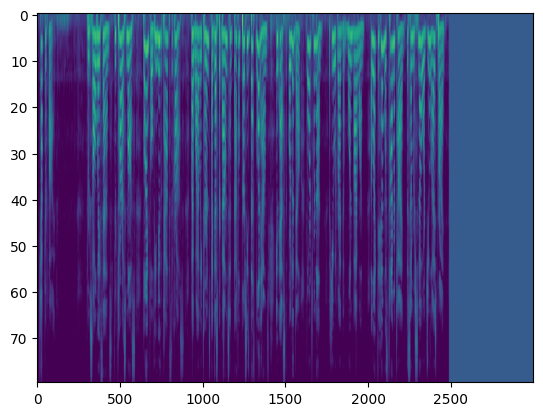

In [ ]:
plt.imshow(mel.cpu()[0], aspect='auto')

<matplotlib.image.AxesImage>

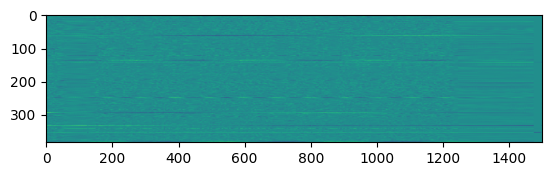

In [ ]:
plt.imshow((embs2).detach().cpu()[0].T)

In [ ]:
tokenizer.decode_with_timestamps(embmodel.decode(embs2[0], whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False)).tokens)

"<|0.00|> Chapter 5 Through Saulway Sans, through Taurus Moss, blindfold he knew the paths to cross.<|9.36|><|9.36|> By wildly turns by desperate bounds had baffled Percy's best bloodhounds in esque or<|15.28|><|15.28|> liddell, ford were none, but he would ride them one by one.<|20.12|><|20.12|>"

<matplotlib.image.AxesImage>

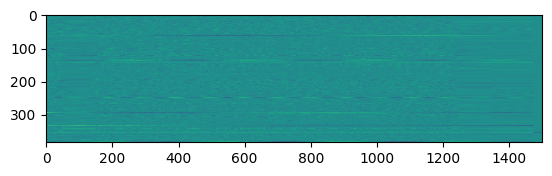

In [ ]:
plt.imshow((embs3).detach().cpu().T)

In [ ]:
tokenizer.decode_with_timestamps(embmodel.decode(embs3, whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False)).tokens)

"<|0.00|> Chapter 5 Through Saulway Sans, through Taurus Moss, blindfold he knew the paths to cross.<|9.36|><|9.36|> By wildly turns by desperate bounds had baffled Percy's best bloodhounds in esque or<|15.28|><|15.28|> liddell, ford were none, but he would ride them one by one.<|20.12|><|20.12|>"

<matplotlib.image.AxesImage>

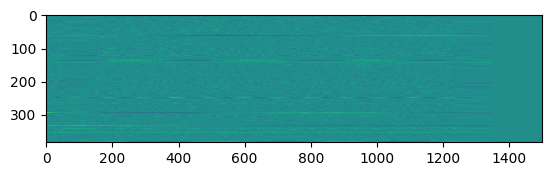

In [ ]:
plt.imshow((embs4).detach().cpu().T)

In [ ]:
tokenizer.decode_with_timestamps(embmodel.decode(embs4, whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False)).tokens)

"<|0.00|> Chapter 5 Through Saulway Sans, through Taurus Moss, blindfold he knew the paths to cross.<|9.36|><|9.36|> By Wiley turns by desperate bounds had baffled Percy's best bloodhounds in esque or<|15.28|><|15.28|> liddell, ford were none, but he would ride them one by one.<|20.12|><|20.12|>"

In [ ]:
N_FRAMES

3000

In [ ]:
(end - start)//2

1246

In [ ]:
for start, end, text in slices:
    print(start, end)
    sample = audio[0,:,(max(start-50, 0))*160:(end-50)*160]
    torchaudio.save(f'slicing-test-{start}.wav', sample.cpu(), 16000)
    mel = whisper.pad_or_trim(whisper.log_mel_spectrogram(sample), N_FRAMES)
    embs = embmodel.encoder(mel)[:, :(end-start)//2]
    stoks = vqmodel.encode(embs)
#     new_text = embmodel.decode(torch.cat([embs, torch.zeros(1500-embs.shape[0],384).cuda()]), whisper.DecodingOptions(language='en', suppress_blank=False, suppress_tokens=False))
    display(HTML(f'<p>{text}, {stoks.shape}</p><audio controls src="./slicing-test-{start}.wav"></audio>'))

0 2836


2836 5328


5328 8148


8148 10640


10640 13472


Let's implement this step by step first:

In [ ]:
#| export
# same as above but rolled into a function
def encode_stoks_and_txt(whmodel, embmodel, vqmodel, audio):
    """Encode the given `audio` (tensor or file name) into Whisper embeddings and lists of text tokens.
    Uses the given `whmodel` (see `load_model`).
    """
    if isinstance(audio, (Path, str)):
        audio = load(audio, newsr=whisper.audio.SAMPLE_RATE)
    slices = transcribe(whmodel, audio[0,0], language='en', verbose=False)
    texts = []
    stoks = []
    for start, end, text in slices:
        sample = audio[0,:,(max(start-50, 0))*160:(end-50)*160]
        with torch.no_grad():
            mel = whisper.pad_or_trim(whisper.log_mel_spectrogram(sample), N_FRAMES)
            embs = embmodel.encoder(mel)[:, :(end-start)//2]
            stoks.append(vqmodel.encode(embs).cpu())
            texts.append(text)
    return stoks, texts

In [ ]:
stoks, texts = encode_stoks_and_txt(whmodel, embmodel, vqmodel, datadir/'small/200/spy_cooper_librivox_64kb_mp3/spy_05_cooper_64kb.flac')
len(stoks), len(texts)

NameError: name 'whmodel' is not defined

In [ ]:
#| export
@call_parse
def extract_stoks_and_txt(
        srcdir:Path,  # source dir, should contain *.flac files
        outdir:Path,  # output dir, will get the *.semb and *.ttoks files
        model:Path,   # model path (vqmodel2-tiny-1000h.pth)
    ): 
    "Convert audio files to .semb files with Whisper embeddings and .ttoks with text tokens"
    whmodel, embmodel = load_model()
    from spear_tts_pytorch.extract_stoks import RQBottleneckTransformer
    vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1)
    vqmodel.load_state_dict(torch.load(model))
    vqmodel.eval().cuda();
    
    outdir.mkdir(exist_ok=True, parents=True)
    for name in progress_bar(list(srcdir.rglob('*.flac'))):
        stoks, texts = encode_stoks_and_txt(whmodel, embmodel, vqmodel, name)
        for i in range(len(stoks)):
            torch.save(stoks[i], outdir/f'{name.stem}-{i}.stoks')
            with open(outdir/f'{name.stem}-{i}.txt', 'w') as f:
                f.write(texts[i])
        import gc; gc.collect()
        torch.cuda.empty_cache()

In [ ]:
# extract all embeddings for a couple of speakers
speakers = [1649]
#speakers = [1649, 2156, 1901, 2607, 2234, 1743, 1614, 3657, 204, 3488, 19, 107, 2162, 1212, 4174]

# a faster version: parallel --eta -j10 spear_extract_semantic /mnt/small/{} /mnt/semantic-small/{} ::: 1649 2156 1901 2607 2234 1743 1614 3657 204 3488 19 107 2162 1212 4174
mb = master_bar(speakers)
for spkid in mb:
    extract_stoks_and_txt(datadir/'small'/str(spkid), datadir/'stoks-txt-small'/str(spkid), './vqmodel2-tiny-1000h.pth')

 83%|████████▎ | 70530/84715 [00:29<00:05, 2419.03frames/s]


KeyboardInterrupt: 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()